В этом занятии вам предстоит продолжить пример с лекции и протестировать несколько других гипотез.

Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

### Вопросы для проверки:
1. Проверьте, есть ли различия в размерах оттока клиентов в разных городах (`churn`, `city`)
2. Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (`city`, `trips_in_first_30_days`)
3. Может ли отток быть связан с активностью в первые 30 дней после регистрации? (`churn`, `trips_in_first_30_days`)  

Перед проведением тестов проверьте распределения переменных, а также удовлетворяются ли параметрические условия. В зависимости от этого выберите правильный метод (схема выбора – здесь).   
Возможно пригодятся:
```
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova 
```


### Описание [данных](https://stepik.org/media/attachments/lesson/406362/churn.csv)
`city` – город  
`phone` – основное устройство, которое использует водитель  
`signup_date` – дата регистрации аккаунта (YYYYMMDD)  
`last_trip_date` – дата последней поездки (YYYYMMDD)  
`avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации  
`avg_rating_by_driver` – средняя оценка поездок водителем  
`avg_rating_of_driver` – средняя оценка поездок водителя  
`surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)  
`avg_surge` – средний множитель всплеска за все поездки этого водителя  
`trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации  
`luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль  
`weekday_pct` – процент поездок пользователя, совершенных в будние дни  

In [72]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import chi2_contingency, shapiro, kruskal, mannwhitneyu  # chi2 
import scikit_posthocs as sp
sns.set(rc = {'figure.figsize' :(16, 6)}, style = 'whitegrid')

In [7]:
df=pd.read_csv('https://stepik.org/media/attachments/lesson/406362/churn.csv',parse_dates=['signup_date','last_trip_date'])

In [8]:
df

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0          3.67                   5.0                   4.7       1.10   
1          8.26                   5.0                   5.0       1.00   
2          0.77                   5.0                   4.3       1.00   
3          2.36                   4.9                   4.6       1.14   
4          3.13                   4.9                   4.4       1.19   
...         ...                   ...                   ...        ...   
49995      5.63                   4.2                   5.0       1.00   
49996      0.00                   4.0                   NaN       1.00   
49997      3.86                   5.0                   5.0       1.00   
49998      4.58                   3.5                   3.0       1.00   
49999      3.49                   5.0                   NaN       1.00   

                 city last_trip_date    phone signup_date  surge_pct  \
0      King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1             Astapor     2014-05-05  Android  2014-01-29        0.0   
2             Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3      King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4          Winterfell     2014-03-15  Android  2014-01-27       11.8   
...               ...            ...      ...         ...        ...   
49995  King's Landing     2014-06-05   iPhone  2014-01-25        0.0   
49996         Astapor     2014-01-25   iPhone  2014-01-24        0.0   
49997      Winterfell     2014-05-22  Android  2014-01-31        0.0   
49998         Astapor     2014-01-15   iPhone  2014-01-14        0.0   
49999         Astapor     2014-04-20  Android  2014-01-18        0.0   

       trips_in_first_30_days  luxury_car_user  weekday_pct  
0                           4             True         46.2  
1                           0            False         50.0  
2                           3            False        100.0  
3                           9             True         80.0  
4                          14            False         82.4  
...                       ...              ...          ...  
49995                       0            False        100.0  
49996                       1            False          0.0  
49997                       0             True        100.0  
49998                       2            False        100.0  
49999                       0            False          0.0  

[50000 rows x 12 columns]

In [35]:
df.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
day_no_active                      int64
churn                              int64
dtype: object

In [10]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней.

In [26]:
df['day_no_active']=(df.last_trip_date.max()-df.last_trip_date).dt.days

In [27]:
df

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0          3.67                   5.0                   4.7       1.10   
1          8.26                   5.0                   5.0       1.00   
2          0.77                   5.0                   4.3       1.00   
3          2.36                   4.9                   4.6       1.14   
4          3.13                   4.9                   4.4       1.19   
...         ...                   ...                   ...        ...   
49995      5.63                   4.2                   5.0       1.00   
49996      0.00                   4.0                   NaN       1.00   
49997      3.86                   5.0                   5.0       1.00   
49998      4.58                   3.5                   3.0       1.00   
49999      3.49                   5.0                   NaN       1.00   

                 city last_trip_date    phone signup_date  surge_pct  \
0      King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1             Astapor     2014-05-05  Android  2014-01-29        0.0   
2             Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3      King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4          Winterfell     2014-03-15  Android  2014-01-27       11.8   
...               ...            ...      ...         ...        ...   
49995  King's Landing     2014-06-05   iPhone  2014-01-25        0.0   
49996         Astapor     2014-01-25   iPhone  2014-01-24        0.0   
49997      Winterfell     2014-05-22  Android  2014-01-31        0.0   
49998         Astapor     2014-01-15   iPhone  2014-01-14        0.0   
49999         Astapor     2014-04-20  Android  2014-01-18        0.0   

       trips_in_first_30_days  luxury_car_user  weekday_pct  day_no_active  
0                           4             True         46.2             14  
1                           0            False         50.0             57  
2                           3            False        100.0            175  
3                           9             True         80.0              2  
4                          14            False         82.4            108  
...                       ...              ...          ...            ...  
49995                       0            False        100.0             26  
49996                       1            False          0.0            157  
49997                       0             True        100.0             40  
49998                       2            False        100.0            167  
49999                       0            False          0.0             72  

[50000 rows x 13 columns]

In [21]:
df = df.drop('day', axis=1)

In [37]:
df['churn']=df.day_no_active.apply(lambda x: 'churn' if x > 30  else 'no_churn' )

In [38]:
df

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0          3.67                   5.0                   4.7       1.10   
1          8.26                   5.0                   5.0       1.00   
2          0.77                   5.0                   4.3       1.00   
3          2.36                   4.9                   4.6       1.14   
4          3.13                   4.9                   4.4       1.19   
...         ...                   ...                   ...        ...   
49995      5.63                   4.2                   5.0       1.00   
49996      0.00                   4.0                   NaN       1.00   
49997      3.86                   5.0                   5.0       1.00   
49998      4.58                   3.5                   3.0       1.00   
49999      3.49                   5.0                   NaN       1.00   

                 city last_trip_date    phone signup_date  surge_pct  \
0      King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1             Astapor     2014-05-05  Android  2014-01-29        0.0   
2             Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3      King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4          Winterfell     2014-03-15  Android  2014-01-27       11.8   
...               ...            ...      ...         ...        ...   
49995  King's Landing     2014-06-05   iPhone  2014-01-25        0.0   
49996         Astapor     2014-01-25   iPhone  2014-01-24        0.0   
49997      Winterfell     2014-05-22  Android  2014-01-31        0.0   
49998         Astapor     2014-01-15   iPhone  2014-01-14        0.0   
49999         Astapor     2014-04-20  Android  2014-01-18        0.0   

       trips_in_first_30_days  luxury_car_user  weekday_pct  day_no_active  \
0                           4             True         46.2             14   
1                           0            False         50.0             57   
2                           3            False        100.0            175   
3                           9             True         80.0              2   
4                          14            False         82.4            108   
...                       ...              ...          ...            ...   
49995                       0            False        100.0             26   
49996                       1            False          0.0            157   
49997                       0             True        100.0             40   
49998                       2            False        100.0            167   
49999                       0            False          0.0             72   

          churn  
0      no_churn  
1         churn  
2         churn  
3      no_churn  
4         churn  
...         ...  
49995  no_churn  
49996     churn  
49997     churn  
49998     churn  
49999     churn  

[50000 rows x 14 columns]

In [40]:
df.churn.value_counts()

churn       31196
no_churn    18804
Name: churn, dtype: int64

<AxesSubplot:xlabel='churn', ylabel='Count'>

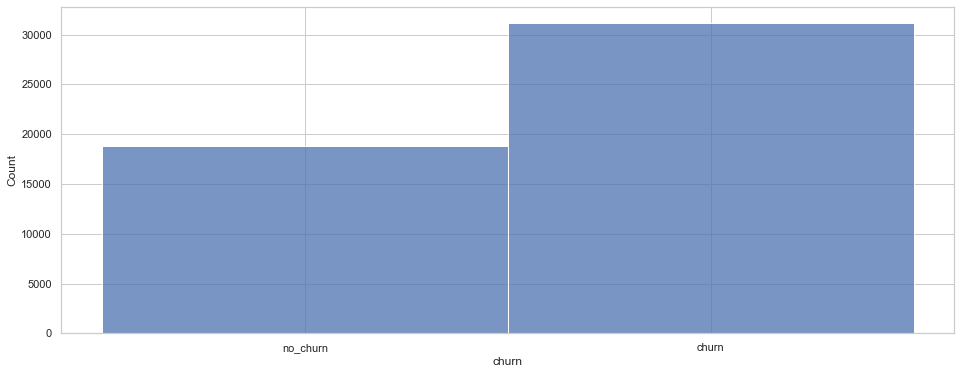

In [45]:
sns.histplot(data=df, x='churn')

Видим, что очень много пользователей не использовали сервис в последнем месяце. Нужно разобраться, какие факторы могут влиять на отток водителей.

Проверим, есть ли различия в размерах оттока клиентов в разных городах (churn, city).

In [43]:
city_churn=df.groupby(['city','churn'],as_index=False).agg({'avg_dist':'count'})

In [46]:
city_churn

city     churn  avg_dist
0         Astapor     churn     12306
1         Astapor  no_churn      4228
2  King's Landing     churn      3767
3  King's Landing  no_churn      6363
4      Winterfell     churn     15123
5      Winterfell  no_churn      8213

<AxesSubplot:xlabel='city', ylabel='avg_dist'>

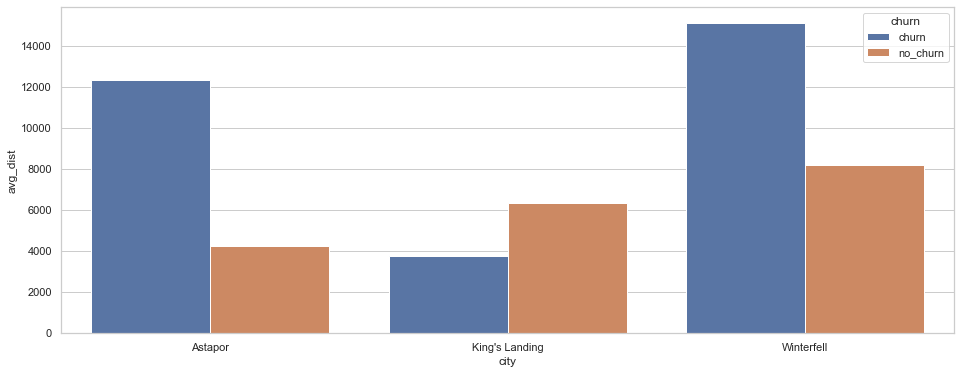

In [47]:
sns.barplot(x='city',y='avg_dist', hue='churn',data=city_churn)

Самый наибольший отток в городе Winterfell

Проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные следовательно нужен хи-квадрат.

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [54]:
# Хи-квадрат
stat, p_value, *other = chi2_contingency(pd.crosstab(df.churn, df.city))

In [55]:
stat, p_value

(3821.5510225559633, 0.0)

Нулевая гипотеза отклоняется, поскольку p-value < 0.05. Иначе говоря, имеется взаимосвязь между переменными churn и city.

Проверим, есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

In [58]:
# тест на нормальность распределения активности в первые 30 дней в "Astapor"
shapiro(df[df.city == "Astapor"].trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.5502306222915649, pvalue=9.80908925027372e-45)

In [59]:
# тест на нормальность распределения активности в первые 30 дней в "King's Landing"
shapiro(df[df.city == "King's Landing"].trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.5889772176742554, pvalue=2.1159606811304738e-43)

In [63]:
# тест на нормальность распределения активности в первые 30 дней в "Winterfell"
shapiro(df[df.city == "Winterfell"].trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.6767933368682861, pvalue=6.7066705021971475e-40)

p-value < 0.5 отклоняю нулевую гипотезу о нормальности равспределения

In [67]:
df_Astapor=df[df.city == "Astapor"].trips_in_first_30_days

<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='Count'>

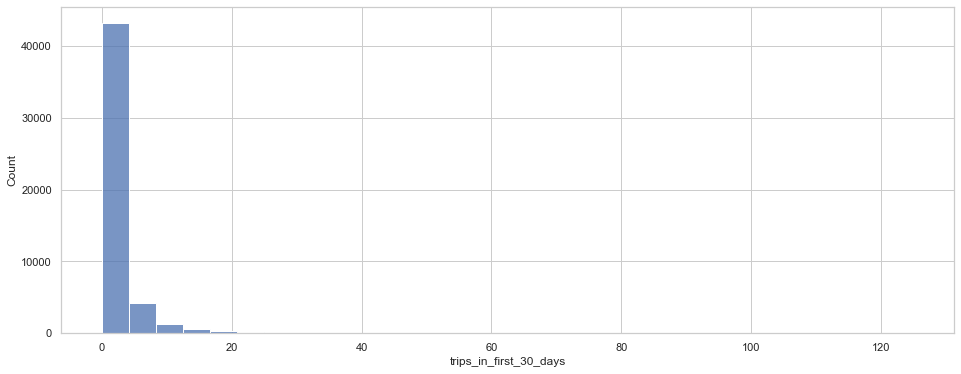

In [77]:
sns.histplot(data=df,x='trips_in_first_30_days',bins=30)

количество групп 3 - используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса.

In [69]:
kruskal(df[df.city == "Astapor"].trips_in_first_30_days,df[df.city == "Winterfell"].trips_in_first_30_days,df[df.city == "King's Landing"].trips_in_first_30_days)

KruskalResult(statistic=221.32105325320535, pvalue=8.724567791804361e-49)

p-value очень маленький, следовательно, мы вынуждены отклонить нулевую гипотезу об отсутствии различий. Другими словами, есть разница в активности в первые 30 дней в разных городах.

Теперь проверим, может ли отток быть связан с активностью в первые 30 дней после регистрации.

Снова проверка на нормальность распределений.

In [78]:
# тест на нормальность распределения активности в первые 30 дней у ушедших водителей
shapiro(df.query('churn == "churn"').trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.4467275142669678, pvalue=0.0)

In [79]:
# тест на нормальность распределения активности в первые 30 дней у ушедших водителей
shapiro(df.query('churn == "no_churn"').trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.6359916925430298, pvalue=1.301806273357755e-41)

Снова распределения ненормальные,p-value < 0.05 - распределения не являются нормальными, количество групп 2 - используем U-критерий Манна-Уитни.

In [87]:
mannwhitneyu(df.query('churn == "churn"').trips_in_first_30_days,df.query('churn == "no_churn"').trips_in_first_30_days)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

<AxesSubplot:xlabel='churn', ylabel='trips_in_first_30_days'>

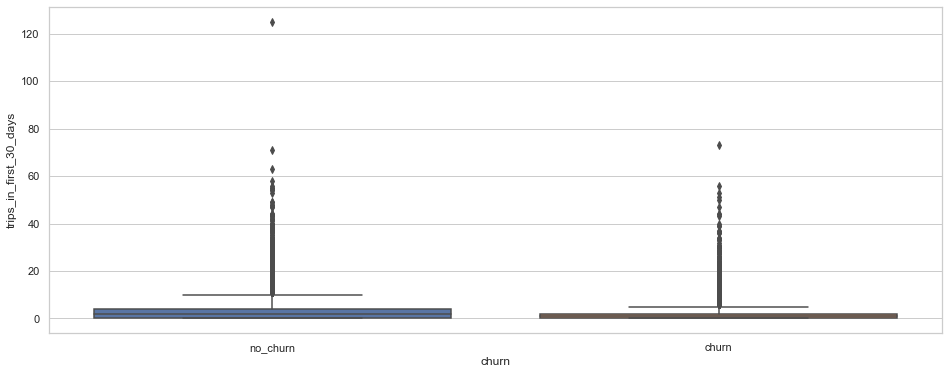

In [88]:
sns.boxplot(data=df, x='churn', y='trips_in_first_30_days')

In [89]:
df.query('churn == "churn"').trips_in_first_30_days.median()

1.0

In [90]:
df.query('churn == "no_churn"').trips_in_first_30_days.median()

2.0

# Результат статистически значимый тк p-value<0.05 , ушедшие пользователи были менее активны в первые 30 дней со дня регистрации.